In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import glob # lista di files in formato *.estensione
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
import tqdm
from scipy.fftpack import fft

In [3]:
X = pd.read_pickle("X-2s.pkl")
X = X.drop("user", axis=1)
y = pd.read_pickle("y-2s.pkl")
espl = pd.read_pickle("espl.pkl")

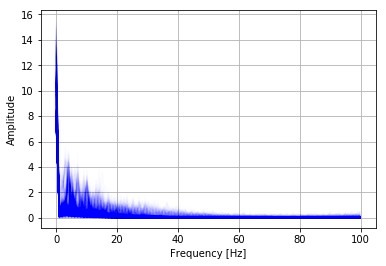

In [4]:
T = 10*0.001  # sampling interval 
N = 200
fftX = pd.DataFrame(fft(X))
#create new x-axis: frequency from signal
xf = np.linspace(0.0, 1.0/T, N//2)
#plot results
for i in range(fftX.shape[0]):
    plt.plot(xf, np.abs(fftX.loc[i,0:N//2-1]) * 1/N, color="blue", alpha=0.007, solid_capstyle="butt")

plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.grid()

In [6]:
fftX = fftX.abs()
#fftX["intTrapz"] = espl["intTrapz"]
#fftX["maxA"] = espl["maxA"]
#fftX["MVDeriv"] = espl["MVDeriv"]
#fftX["meanA"] = espl["meanA"]
fftX.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,1449.192062,105.663888,255.141241,217.015397,96.563470,52.598946,59.117761,49.197641,26.915050,26.743124,...,15.894157,26.743124,26.915050,49.197641,59.117761,52.598946,96.563470,217.015397,255.141241,105.663888
1,1557.451876,56.469098,241.278035,261.630744,90.590216,123.582398,29.418615,36.787541,72.861781,45.249780,...,60.652906,45.249780,72.861781,36.787541,29.418615,123.582398,90.590216,261.630744,241.278035,56.469098
2,1537.961104,72.668086,199.071741,338.294475,72.308110,22.748375,61.240637,33.854203,47.496639,42.384590,...,23.726083,42.384590,47.496639,33.854203,61.240637,22.748375,72.308110,338.294475,199.071741,72.668086
3,1510.984139,115.123564,44.473886,328.959114,67.083707,79.490764,52.863140,62.045821,41.690006,38.027200,...,20.182980,38.027200,41.690006,62.045821,52.863140,79.490764,67.083707,328.959114,44.473886,115.123564
4,1596.004236,69.691853,263.153295,273.375024,147.938671,87.516335,15.491909,21.203650,28.811889,8.266724,...,3.230586,8.266724,28.811889,21.203650,15.491909,87.516335,147.938671,273.375024,263.153295,69.691853


In [7]:
from funzioni import indice_gini
from funzioni import tasso_errata_classificazione
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [8]:
X_train, X_val, y_train, y_val = train_test_split(fftX, y, test_size=0.25, random_state=42)

Accuratezza DecisionTreeClassifier(): 89.14%


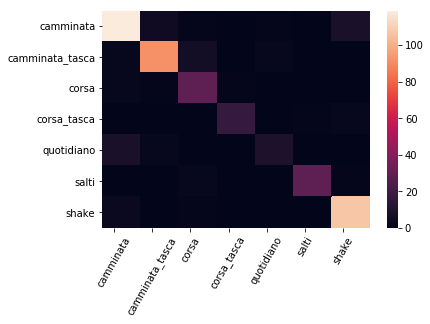

In [9]:
dtc = Pipeline([ 
    ("tree", DecisionTreeClassifier(random_state=42))
])

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_val)
dtc_acc = accuracy_score(y_val, y_pred)

#print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))
print("Accuratezza DecisionTreeClassifier(): {:.2f}%".format(100 * dtc_acc))
sns.heatmap(confusion_matrix(y_val, y_pred), xticklabels=y.unique(), yticklabels=y.unique())
plt.xticks(np.arange(len(y.unique()))+0.3, y.unique(), rotation=60)
plt.show()

In [10]:
from sklearn.model_selection import ParameterGrid
import tqdm

In [11]:
param_grid = ParameterGrid({
    'tree__max_depth': np.arange(1, dtc.named_steps["tree"].tree_.max_depth),
    'tree__min_samples_leaf': 2 ** np.arange(9),
})
print(param_grid.param_grid)

[{'tree__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), 'tree__min_samples_leaf': array([  1,   2,   4,   8,  16,  32,  64, 128, 256], dtype=int32)}]


In [12]:
risultati = []

for params in tqdm.tqdm(param_grid):
    dtc.set_params(**params)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_val)
    params["accuracy_score"] = accuracy_score(y_val, y_pred)
    risultati.append(params)

risultati = pd.DataFrame(risultati).sort_values(["accuracy_score", "tree__max_depth"], ascending=[False, True])
risultati.reset_index(drop=True, inplace=True)
print("Primi 5:")
display(risultati.head())

print("Ultimi 5:")
risultati.tail()

100%|██████████████████████████████████████| 117/117 [00:23<00:00,  4.88it/s]


Primi 5:


,accuracy_score,tree__max_depth,tree__min_samples_leaf
0,0.900222,12,1
1,0.893570,9,1
2,0.889135,7,1
3,0.889135,8,1
4,0.889135,8,2


Ultimi 5:


,accuracy_score,tree__max_depth,tree__min_samples_leaf
112,0.496674,1,16
113,0.496674,1,32
114,0.496674,1,64
115,0.496674,1,128
116,0.496674,1,256


In [13]:
from funzioni import grafico_metrica_iperparametro

Accuratezza DecisionTreeClassifier(): 89.1%
Accuratezza DecisionTreeClassifier(max_depth=12, min_samples_leaf=1): 90.0%
[[121   4   1   0   1   0   7]
 [  2  93   6   0   1   0   0]
 [  1   1  29   1   0   0   1]
 [  0   0   2  17   0   1   0]
 [  7   2   0   0  10   0   0]
 [  0   2   0   1   0  29   0]
 [  3   0   1   0   0   0 107]]


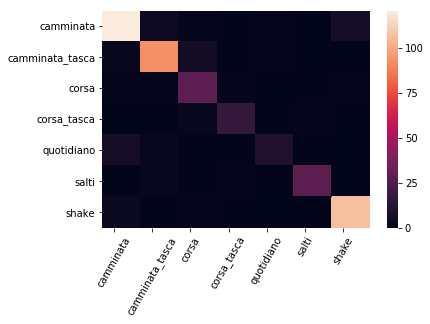

In [24]:
max_depth = risultati.loc[0, "tree__max_depth"]
min_samples_leaf = risultati.loc[0, "tree__min_samples_leaf"]

dtc_tun = Pipeline([
    ("tree", DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42))
])

dtc_tun.fit(X_train, y_train)

y_pred = dtc_tun.predict(X_val)
dtc_tun_acc = accuracy_score(y_val, y_pred)

#print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))
print("Accuratezza DecisionTreeClassifier(): {:.1f}%".format(100 * dtc_acc))
print("Accuratezza DecisionTreeClassifier(max_depth={}, min_samples_leaf={}): {:.1f}%".format(
    max_depth, min_samples_leaf, 100 * dtc_tun_acc))
print(confusion_matrix(y_val, y_pred))
sns.heatmap(confusion_matrix(y_val, y_pred), xticklabels=y.unique(), yticklabels=y.unique())
plt.xticks(np.arange(len(y.unique()))+0.3, y.unique(), rotation=60)
plt.show()

In [26]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
tsne = TSNE(n_components=2, random_state=42)
fftTSNE = tsne.fit_transform(fftX)

pca = PCA(n_components=2, random_state=42)
fftPCA = pca.fit_transform(fftX)

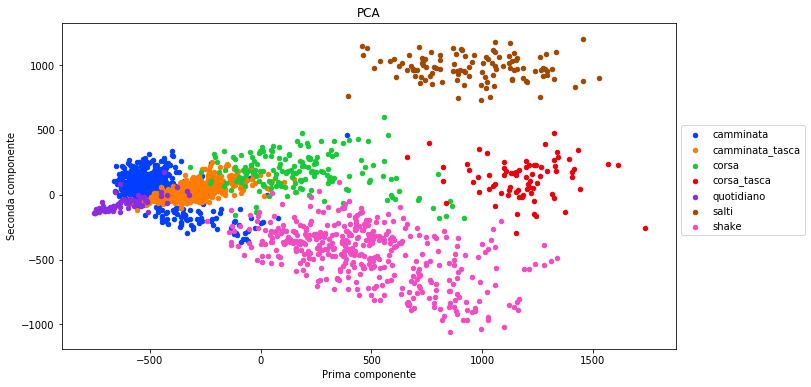

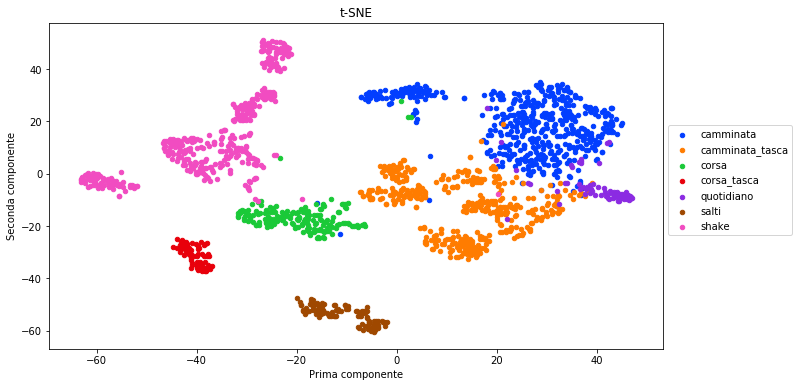

In [28]:
from funzioni import ScatterGroup

for title,dat in zip(["PCA","t-SNE"], [fftPCA, fftTSNE]):
    fig, ax = ScatterGroup(pd.DataFrame(dat, columns=["Prima componente", "Seconda componente"]),
                       grp=y, palette="bright")
    fig.set_figwidth(11)
    fig.set_figheight(6)
    ax.set_title(title)
    plt.legend(bbox_to_anchor=(1,0.7))

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [31]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

C:\Users\zagod\Anaconda3\envs\msbd\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

Accuratezza LDA su FT: 92.5%
[[128   3   1   0   2   0   0]
 [  7  93   0   0   2   0   0]
 [  2   1  30   0   0   0   0]
 [  0   0   0  20   0   0   0]
 [  6   3   0   0  10   0   0]
 [  0   0   0   0   0  32   0]
 [  0   7   0   0   0   0 104]]


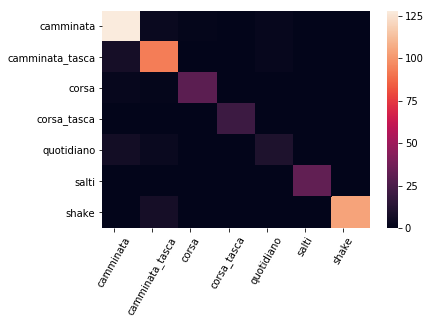

In [35]:
y_pred_lda = lda.predict(X_val)
print("Accuratezza LDA su FT: {:.1f}%".format(100*accuracy_score(y_val, y_pred_lda)))
print(confusion_matrix(y_val, y_pred_lda))
sns.heatmap(confusion_matrix(y_val, y_pred_lda), xticklabels=y.unique(), yticklabels=y.unique())
plt.xticks(np.arange(len(y.unique()))+0.3, y.unique(), rotation=60)
plt.show()

In [37]:
qda = QuadraticDiscriminantAnalysis()

qda.fit(X_train, y_train)

C:\Users\zagod\Anaconda3\envs\msbd\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\zagod\Anaconda3\envs\msbd\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\zagod\Anaconda3\envs\msbd\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\zagod\Anaconda3\envs\msbd\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\zagod\Anaconda3\envs\msbd\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\zagod\Anaconda3\envs\msbd\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

Accuratezza QDA su FT: 80.5%
[[133   1   0   0   0   0   0]
 [  5  87   1   0   0   0   9]
 [ 12   1  16   0   0   0   4]
 [  0   0   1   0   0   0  19]
 [ 13   3   0   0   0   0   3]
 [  0   0   1   0   0  16  15]
 [  0   0   0   0   0   0 111]]


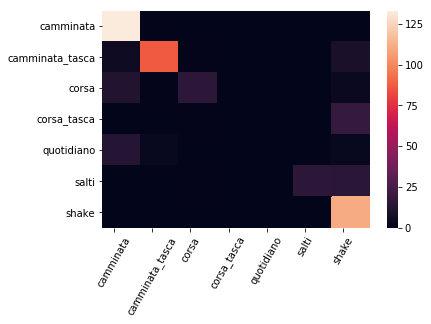

In [39]:
y_pred_qda = qda.predict(X_val)
print("Accuratezza QDA su FT: {:.1f}%".format(100*accuracy_score(y_val, y_pred_qda)))
print(confusion_matrix(y_val, y_pred_qda))
sns.heatmap(confusion_matrix(y_val, y_pred_qda), xticklabels=y.unique(), yticklabels=y.unique())
plt.xticks(np.arange(len(y.unique()))+0.3, y.unique(), rotation=60)
plt.show()